# Generic Imports

In [1]:
import pandas as pd
import numpy as np

# Preprocessing

In [2]:
from preprocessing import event_preprocessing
from preprocessing import drop_unprocessed 

df = pd.read_json('data/15946.json')
df = event_preprocessing(df)
df = drop_unprocessed(df)

player.... complete
type.... complete
play_pattern.... complete
possession_team.... complete
position.... complete
location.... complete
under_pressure.... complete
counterpress.... complete
off_camera.... complete
out.... complete
carry.... complete
ball_receipt.... complete
shot.... complete
dribble.... complete
pass.... complete


# Metric 2

## Preparing data for training model

In [3]:
df2_columns = ["type","play_pattern","possession_team","position","under_pressure","counterpress","out","location_x","location_y","shot_outcome"]
df2 = df[df['location_available']==True][df2_columns].reset_index()
df2 = df2.drop(columns=['index'])

In [4]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3741 entries, 0 to 3740
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   type             3741 non-null   object 
 1   play_pattern     3741 non-null   object 
 2   possession_team  3741 non-null   object 
 3   position         3741 non-null   object 
 4   under_pressure   3741 non-null   bool   
 5   counterpress     3741 non-null   bool   
 6   out              3741 non-null   bool   
 7   location_x       3741 non-null   float64
 8   location_y       3741 non-null   float64
 9   shot_outcome     3741 non-null   object 
dtypes: bool(3), float64(2), object(5)
memory usage: 215.7+ KB


## preparing data for model

In [5]:
# normalizing position data
field_length = 120
field_width = 80
df2['location_x'] = df2['location_x']/field_length
df2['location_y'] = df2['location_y']/field_width

In [6]:
# creating dummies from categorical data
df2 = pd.get_dummies(df2, columns=["type","possession_team","play_pattern","position"])

In [7]:
# labeling when a goal is scored
df2['scored'] = df2['shot_outcome'].apply(lambda x: True if x == 'Goal' else False)
df2 = df2.drop(columns=['shot_outcome'])

# what does it mean for goal to be conceded ???????????

In [8]:
state_len = 3
offset_df = []
for i in range(state_len):
    df2_ = df2[i:-(state_len-i)]
    df2_ = df2_.rename(lambda x: x+f'_{i}',axis='columns').reset_index()
    offset_df.append(df2_)
    print(len(df2_))
    print(df2_.info())

df2 = offset_df[0]
for df2_ in offset_df[1:]:
    df2 = df2.merge(df2_,how='inner')

3738
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3738 entries, 0 to 3737
Data columns (total 52 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   index                                 3738 non-null   int64  
 1   under_pressure_0                      3738 non-null   bool   
 2   counterpress_0                        3738 non-null   bool   
 3   out_0                                 3738 non-null   bool   
 4   location_x_0                          3738 non-null   float64
 5   location_y_0                          3738 non-null   float64
 6   type_Ball Receipt*_0                  3738 non-null   uint8  
 7   type_Ball Recovery_0                  3738 non-null   uint8  
 8   type_Block_0                          3738 non-null   uint8  
 9   type_Carry_0                          3738 non-null   uint8  
 10  type_Clearance_0                      3738 non-null   uint8  
 11  type_Disposs

In [9]:
# TODO: separate by team then join back up
# setting up target
predict_window = 10
scored = list(df2['scored_0']) + ([False] * predict_window)
print(len(scored))
scored_window = list(map(lambda x: any(scored[x:x+predict_window]),range(0,len(scored)-predict_window)))
print(len(scored_window))
df2['scored_window'] = scored_window

3746
3736


In [10]:
# changing True/False to 0/1
df2.replace({False: 0, True: 1}, inplace = True)

In [11]:
df2 = df2.drop(columns=['index'])

In [12]:
X = df2.drop(columns=['scored_window']).to_numpy()
Y = df2['scored_window'].to_numpy()

In [13]:
print(f'input shape: {X.shape}')
print(f'output shape: {Y.shape}')

input shape: (3736, 153)
output shape: (3736,)


In [14]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X,Y,test_size=0.25)

## Training Model

In [15]:
import xgboost as xgb

In [33]:
# Use "hist" for constructing the trees, with early stopping enabled.
clf = xgb.XGBClassifier(tree_method="hist", early_stopping_rounds=10)
# Fit the model, test sets are used for early stopping.
clf.fit(train_X, train_Y, eval_set=[(test_X, test_Y)])

[0]	validation_0-logloss:0.44324
[1]	validation_0-logloss:0.30546
[2]	validation_0-logloss:0.21911
[3]	validation_0-logloss:0.16160
[4]	validation_0-logloss:0.12221
[5]	validation_0-logloss:0.09479
[6]	validation_0-logloss:0.07556
[7]	validation_0-logloss:0.06220
[8]	validation_0-logloss:0.05244
[9]	validation_0-logloss:0.04559
[10]	validation_0-logloss:0.03984
[11]	validation_0-logloss:0.03557
[12]	validation_0-logloss:0.03261
[13]	validation_0-logloss:0.03040
[14]	validation_0-logloss:0.02806
[15]	validation_0-logloss:0.02677
[16]	validation_0-logloss:0.02532
[17]	validation_0-logloss:0.02436
[18]	validation_0-logloss:0.02361
[19]	validation_0-logloss:0.02307
[20]	validation_0-logloss:0.02284
[21]	validation_0-logloss:0.02233
[22]	validation_0-logloss:0.02216
[23]	validation_0-logloss:0.02178
[24]	validation_0-logloss:0.02109
[25]	validation_0-logloss:0.02086
[26]	validation_0-logloss:0.02039
[27]	validation_0-logloss:0.02021
[28]	validation_0-logloss:0.01996
[29]	validation_0-loglos

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

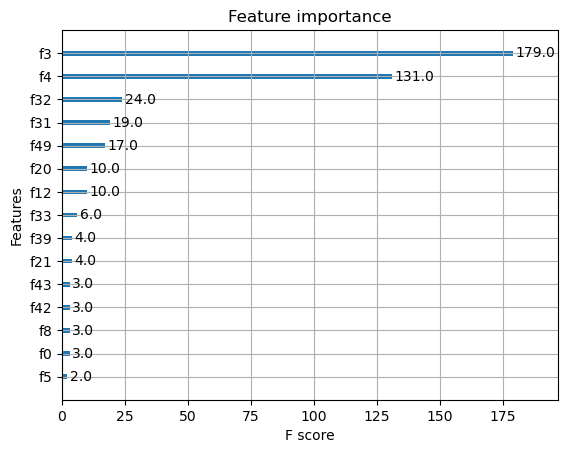

In [34]:
xgb.plot_importance(clf)

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
predict_Y = clf.predict(test_X)
accuracy_score(predict_Y, test_Y)

0.9957173447537473

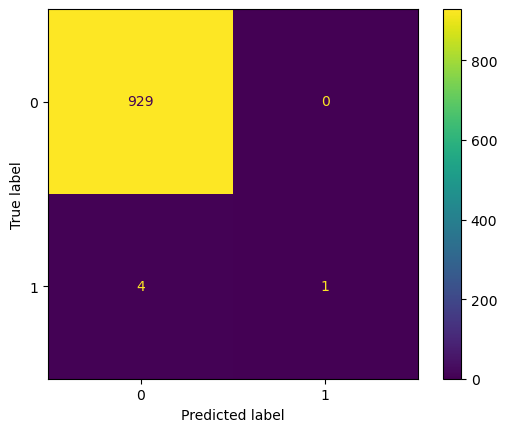

In [41]:
confusion_matrix = confusion_matrix(test_Y, predict_Y)
cm_display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[0,1])

cm_display.plot()

There aren't that many goals in a game, joining values from other games is necessary